## Get image from a Lepton camera

Show it has a Gray8 (heatmap) image.

[ WARN:0@194.439] global cap_v4l.cpp:913 open VIDEOIO(V4L2:/dev/video3): can't open camera by index
[ WARN:0@194.439] global cap.cpp:478 open VIDEOIO(V4L2): backend is generally available but can't be used to capture by index


VideoCapture: True
Frame healthy? True


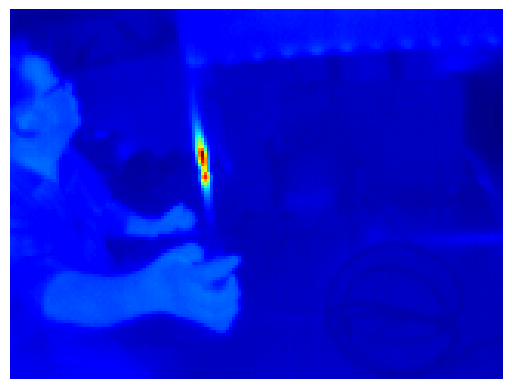

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from flirpy.camera.lepton import Lepton

with Lepton() as cam:
  cam.setup_video()
  print("VideoCapture:", cam.cap.isOpened())

  result, frame = cam.cap.read() # because cam.grap() breaks
  print("Frame healthy?", result)

  if not result:
    print("Can't receive frame (stream end?). Exiting ...")
  else:
    frame = frame.reshape((120 + 2, 320)) # 120 + 2 for telemetry & 160 * 2

    # Gray16
    frame_16 = frame.view(np.uint16)
    frame_16 = frame_16[:-2, :]  # remove telemetry
    cv2.imwrite("lepton_frame_16.tiff", frame_16)

    # Gray8 to visualize
    norm_frame = cv2.normalize(frame_16, None, 0, 255, cv2.NORM_MINMAX)
    norm_frame = norm_frame.astype(np.uint8)
    plt.imshow(norm_frame, cmap='jet', interpolation='nearest')
    plt.axis("off")
    plt.show()

  cam.cap.release()


## Get temperature from a pixel in a Gray16 image

Gray16 image shape: (120, 160)
Pixel at (62, 47) in Gray16 image: 34686
Pixel at (62, 47) in Celsius: 73.71000000000004


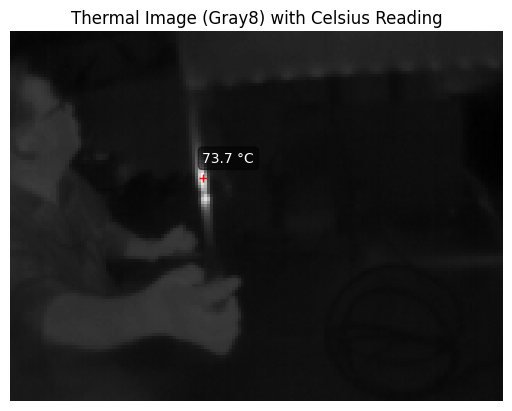

In [13]:
import cv2

gray16_image = cv2.imread("lepton_frame_16.tiff", cv2.IMREAD_UNCHANGED)
print("Gray16 image shape:", gray16_image.shape)  # should be (120, 160)

x = 62
y = 47

# calculate the pixel value in Celsius (through the gray16 image)
pixel_value = gray16_image[y, x]
print(f"Pixel at ({x}, {y}) in Gray16 image:", pixel_value)
pixel_celsius = (pixel_value / 100) - 273.15
print(f"Pixel at ({x}, {y}) in Celsius:", pixel_celsius)

# convert the gray16 image into a gray8 to show the result
gray8_image = np.zeros((120, 160), dtype=np.uint8)
gray8_image = cv2.normalize(gray16_image, gray8_image, 0, 255, cv2.NORM_MINMAX)
gray8_image = np.uint8(gray8_image)

# plot
fig, ax = plt.subplots()
ax.imshow(gray8_image, cmap="gray")

ax.plot(x, y, "r+")
ax.text(
  x,
  y - 5,
  f"{pixel_celsius:.1f} °C",
  color="white",
  fontsize=10,
  bbox=dict(facecolor="black", alpha=0.5, boxstyle="round,pad=0.3"),
)

ax.set_title("Thermal Image (Gray8) with Celsius Reading")
plt.axis("off")
plt.show()

## Get camera video from a Lepton camera

In [1]:
import cv2
import time
import numpy as np
from flirpy.camera.lepton import Lepton
import sys
import datetime

# Initialize Lepton camera
cam = Lepton()
cam.setup_video()
if not cam.cap.isOpened():
    print("Error: Camera not opened.")
    sys.exit(1)
print("VideoCapture:", cam.cap.isOpened())

# CONSTANTS
TELEMETRY_H = 2
FRAME_W = int(cam.cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # = 160
FRAME_H = int(cam.cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) - TELEMETRY_H  # = 120
print(f"Frame size: {FRAME_W}x{FRAME_H}")

# Start video capture
print("Waiting for camera to warm up...")
time.sleep(0.1)
result, frame = cam.cap.read()
if not result:
    print("Can't receive frame. Exiting ...")
    cam.close()
    sys.exit(1)

print("Starting video capture...")
start_time = time.time()
last_time = start_time
sum_time = 0.0
sum_fps = 0.0

frame_count = 0
max_frames = 100
frames_16 = []
frames = []

while frame_count < max_frames:
    result, frame = cam.cap.read()
    if not result:
        print("Can't receive frame. Exiting ...")
        cam.close()
        break

    # height + 2 (for telemetry) & width * 2
    frame = frame.reshape((FRAME_H + TELEMETRY_H, FRAME_W * 2))

    # Gray16
    frame_16 = frame.view(np.uint16)
    frame_16 = frame_16[:-2, :]  # remove telemetry

    # Gray8 to visualize
    norm_frame = cv2.normalize(frame_16, None, 0, 255, cv2.NORM_MINMAX)
    norm_frame = norm_frame.astype(np.uint8)

    # Add frame to [] (in COLORMAP_JET, COLORMAP_INFERNO or COLORMAP_HOT)
    color_frame = cv2.applyColorMap(norm_frame, cv2.COLORMAP_JET)
    frames.append({
        "gray16": frame_16,
        "gray8": norm_frame,
        "color": color_frame
    })

    # See stats for each frame
    now = time.time()
    delta_ms = (now - last_time) * 1000
    last_time = now
    sum_time += delta_ms
    actual_fps = 1000 / delta_ms if delta_ms > 0 else 0
    sum_fps += actual_fps
    # print(f"Frame {frame_count}: {actual_fps:.0f} fps ; Δt = {delta_ms:.3f} ms")
    frame_count += 1

avg_fps = sum_fps / frame_count if frame_count > 0 else 0
print(f"Average FPS: {sum_fps / frame_count:.2f}")
print(f"Average frame time: {sum_time / frame_count:.2f} ms")
end_time = time.time()
print(f"Total time: {end_time - start_time:.2f} seconds")
cam.close()

# Export video from frames
time_stamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
video_writer = cv2.VideoWriter(
    f"lepton_{time_stamp}.avi",
    cv2.VideoWriter_fourcc(*"XVID"),
    fps=avg_fps,
    frameSize=(FRAME_W, FRAME_H),
    isColor=True,
)
for frame in frames:
    video_writer.write(frame["color"])

video_writer.release()
print(f"Saved {frame_count} frames to {time_stamp}.avi")

/home/fermat/Documents/oit/fire-hazard-detection-system/computer-vision/training/.venv/lib/python3.12/site-packages/flirpy/camera/lepton.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[ WARN:0@0.166] global cap_v4l.cpp:913 open VIDEOIO(V4L2:/dev/video3): can't open camera by index
[ WARN:0@0.166] global cap.cpp:478 open VIDEOIO(V4L2): backend is generally available but can't be used to capture by index


VideoCapture: True
Frame size: 160x120
Waiting for camera to warm up...
Starting video capture...
Average FPS: 8.88
Average frame time: 130.88 ms
Total time: 13.09 seconds
Saved 100 frames to 20250711095545.avi
